**Description:**

This is the Jupyter notebook is used to test a few classier: Logistic regression, KNN and Naive Baise (GaussianNB).

**Project Name:** Lending Club

**Team:** Silas Mederer, Jonas Bechthold

**Date:** 2020-10-02 to 2020-10-08

# Setting up & load data

In [29]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("data/df_clean.csv")
df.drop("Unnamed: 0", inplace=True, axis=1)

In [30]:
random_state = 100           # Ensures modeling results can be replicated
pd.set_option('display.max_columns', 50) # Sets maximum columns displayed in tables

In [31]:
def scores(filename=str):
    
    sns.set(font_scale=1.5)
    print("Confusion matrix train")
    print(confusion_matrix(y_train, y_train_pred))

    print("Classification report train")
    print(classification_report(y_train, y_train_pred))

    # Figure test
    conf_mat = pd.crosstab(np.ravel(y_test), np.ravel(y_pred),
                           colnames=["Predicted"], rownames=["Actual"])
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="g")

    plt.title('Confusion Matrix: Test Data')
    plt.savefig(
        f"plots/conf-matrix-test-{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print("Confusion matrix test")
    print(confusion_matrix(y_test, y_pred))

    print("Classification report test")
    print(classification_report(y_test, y_pred))

    # Figure train
    conf_mat = pd.crosstab(np.ravel(y_train), np.ravel(y_train_pred),
                           colnames=["Predicted"], rownames=["Actual"])
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="g")

    plt.title('Confusion Matrix: Training Data')
    plt.savefig(
        f"plots/conf-matrix-train-{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    
def optimization_plots(model):
    print(plot_grid_search(model))
    print(table_grid_search(model))

# Categorial and continuos variables

In [32]:
categorical_var = list(df.select_dtypes('object').columns)
print("categorial var")
print(categorical_var)

categorial var
['grade', 'sub_grade', 'purpose', 'addr_state']


In [33]:
continuous_var = list(df.select_dtypes('int').columns) + list(df.select_dtypes('float').columns)
print("continues var")
print(continuous_var)

continues var
['term_is_36', 'pub_rec_bankruptcies', 'default', 'loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc']


# Correlogram 

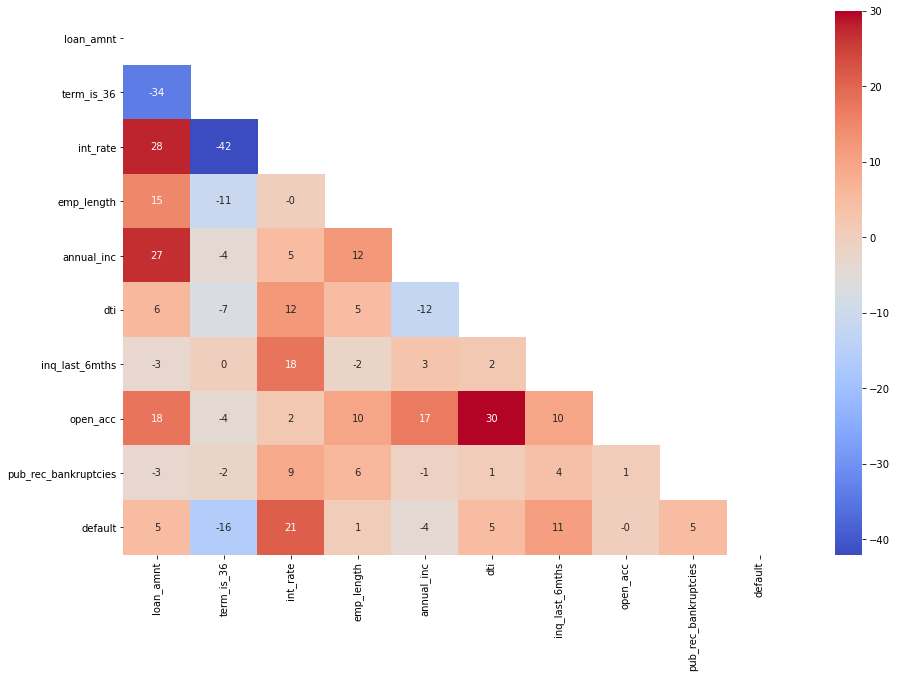

In [34]:
fig, ax = plt.subplots(figsize=(15,10))
mask = np.triu(df.corr())
ax = sns.heatmap(round(df.corr()*100,0)
                 ,annot=True
                 ,mask=mask
                 ,cmap="coolwarm")
plt.savefig('plots/correlogram.png')

# Resample

In [35]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.default==0]
df_minority = df[df.default==1]

target_sample_size = 20000

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,                    # sample with replacement
                                 n_samples=target_sample_size,    # to match majority class
                                 random_state=random_state)                 # reproducible results

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=True,                    # sample with replacement
                                 n_samples=target_sample_size,    # to match majority class
                                 random_state=random_state)                 # reproducible results

print(f"Size of minority df: {df_minority_upsampled.default.value_counts()}")
print(f"Size of majority df: {df_majority_downsampled.default.value_counts()}")

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority_downsampled, df_minority_upsampled])
 
# Display new class counts
df_upsampled.default.value_counts()

Size of minority df: 1    20000
Name: default, dtype: int64
Size of majority df: 0    20000
Name: default, dtype: int64


1    20000
0    20000
Name: default, dtype: int64

In [36]:
df = df_upsampled
df.shape

(40000, 14)

# Get dummies

In [37]:
X = pd.get_dummies(df.copy(), drop_first=True)
X.drop("default", axis=1, inplace=True)
y = df["default"]

# Split

,train abs,train %,test abs,test %,all abs,all %
0,14014,0.5,5986,0.5,20000,0.5
1,13986,0.5,6014,0.5,20000,0.5


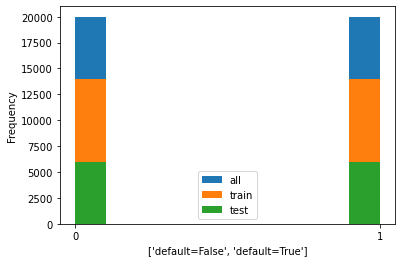

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

# plot
y.plot.hist()
y_train.plot.hist()
y_test.plot.hist()
plt.xlabel(["default=False", "default=True"])
plt.xticks([0, 1])


# dataframe with relative and absolut values
plt.legend(['all','train','test'])
tts_df = pd.DataFrame()
tts_df['train abs'] = round(y_train.value_counts(),2)
tts_df['train %'] = round((y_train.value_counts()/y_train.shape[0]),2)
tts_df['test abs'] = round(y_test.value_counts(),2)
tts_df['test %'] = round((y_test.value_counts()/y_test.shape[0]),2)
tts_df['all abs'] = round(y.value_counts(),2)
tts_df['all %'] = round((y.value_counts()/y.shape[0]),2)
tts_df

# Scale

In [39]:
df.skew()

loan_amnt               1.030521
term_is_36             -0.839821
int_rate                0.142468
emp_length              0.219154
annual_inc              8.380250
dti                    -0.100014
inq_last_6mths          3.418371
open_acc                1.042394
pub_rec_bankruptcies    3.886156
default                 0.000000
dtype: float64

In [40]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

scaling_list = ["loan_amnt","annual_inc"]
scaling_min_max = ["annual_inc"]

def logarithmize(value):
    #print(value)
    logvalue = np.log(value)
    return logvalue

# scaling train with fit transform
X_train[scaling_min_max] = X_train[scaling_min_max].apply(lambda x: logarithmize(x))
X_train[scaling_list] = scaler.fit_transform(X_train[scaling_list])

# scaling test with same scaling parameters as the training set (just transform)
X_test[scaling_min_max] = X_test[scaling_min_max].apply(lambda x: logarithmize(x))
X_test[scaling_list] = scaler.transform(X_test[scaling_list])

# Logistic Regression

Confusion matrix train
[[9146 4868]
 [4756 9230]]
Classification report train
              precision    recall  f1-score   support

           0       0.66      0.65      0.66     14014
           1       0.65      0.66      0.66     13986

    accuracy                           0.66     28000
   macro avg       0.66      0.66      0.66     28000
weighted avg       0.66      0.66      0.66     28000



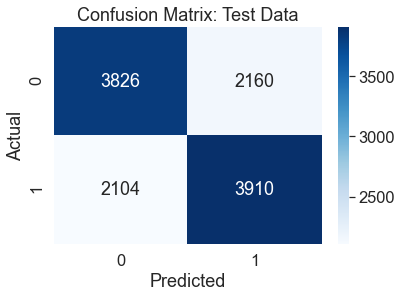

Confusion matrix test
[[3826 2160]
 [2104 3910]]
Classification report test
              precision    recall  f1-score   support

           0       0.65      0.64      0.64      5986
           1       0.64      0.65      0.65      6014

    accuracy                           0.64     12000
   macro avg       0.64      0.64      0.64     12000
weighted avg       0.64      0.64      0.64     12000



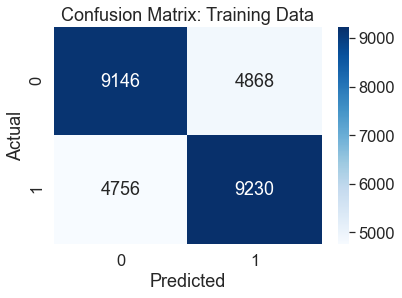

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_train_pred = lr.predict(X_train)

scores("log_reg_raw")

## Optimization

Params came from this source: https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35

In [42]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
C = np.logspace(0, 4, num=10)
penalty = ['l1', 'l2']
solver = ['liblinear', 'saga']
hyperparameters = dict(C=C, penalty=penalty, solver=solver)

# Estimator for use in random search
estimator = LogisticRegression()

# Create the random search model
logreg = RandomizedSearchCV(estimator, hyperparameters, 
                            n_jobs=-1,
                            scoring='recall', 
                            cv=5,
                            n_iter=25, 
                            verbose=1)

# Fit
logreg.fit(X_train, y_train)

print(logreg.best_params_)
print(round(logreg.best_score_,2))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  1.1min finished


{'solver': 'liblinear', 'penalty': 'l2', 'C': 166.81005372000593}
0.66


Note: Best params on 07.October were: {'solver': 'liblinear', 'penalty': 'l1', 'C': 10000.0}

The method down here was created by Juanma Hernández and can be found here Source: https://www.kaggle.com/juanmah/grid-search-utils

In [43]:
# !/usr/bin/env python
"""Utility script with functions to be used with the results of GridSearchCV.

**plot_grid_search** plots as many graphs as parameters are in the grid search results.

**table_grid_search** shows tables with the grid search results.

Inspired in [Displaying the results of a Grid Search](https://www.kaggle.com/grfiv4/displaying-the-results-of-a-grid-search) notebook,
of [George Fisher](https://www.kaggle.com/grfiv4)
"""

import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import pprint
from scipy import stats
from IPython.display import display

__author__ = "Juanma Hernández"
__copyright__ = "Copyright 2019"
__credits__ = ["Juanma Hernández", "George Fisher"]
__license__ = "GPL"
__maintainer__ = "Juanma Hernández"
__email__ = "https://twitter.com/juanmah"
__status__ = "Utility script"


def plot_grid_search(clf):
    """Plot as many graphs as parameters are in the grid search results.

    Each graph has the values of each parameter in the X axis and the Score in the Y axis.

    Parameters
    ----------
    clf: estimator object result of a GridSearchCV
        This object contains all the information of the cross validated results for all the parameters combinations.
    """
    # Convert the cross validated results in a DataFrame ordered by `rank_test_score` and `mean_fit_time`.
    # As it is frequent to have more than one combination with the same max score,
    # the one with the least mean fit time SHALL appear first.
    cv_results = pd.DataFrame(clf.cv_results_).sort_values(by=['rank_test_score', 'mean_fit_time'])

    # Get parameters
    parameters=cv_results['params'][0].keys()

    # Calculate the number of rows and columns necessary
    rows = -(-len(parameters) // 2)
    columns = min(len(parameters), 2)
    # Create the subplot
    fig = make_subplots(rows=rows, cols=columns)
    # Initialize row and column indexes
    row = 1
    column = 1

    # For each of the parameters
    for parameter in parameters:

        # As all the graphs have the same traces, and by default all traces are shown in the legend,
        # the description appears multiple times. Then, only show legend of the first graph.
        if row == 1 and column == 1:
            show_legend = True
        else:
            show_legend = False

        # Mean test score
        mean_test_score = cv_results[cv_results['rank_test_score'] != 1]
        fig.add_trace(go.Scatter(
            name='Mean test score',
            x=mean_test_score['param_' + parameter],
            y=mean_test_score['mean_test_score'],
            mode='markers',
            marker=dict(size=mean_test_score['mean_fit_time'],
                        color='SteelBlue',
                        sizeref=2. * cv_results['mean_fit_time'].max() / (40. ** 2),
                        sizemin=4,
                        sizemode='area'),
            text=mean_test_score['params'].apply(
                lambda x: pprint.pformat(x, width=-1).replace('{', '').replace('}', '').replace('\n', '<br />')),
            showlegend=show_legend),
            row=row,
            col=column)

        # Best estimators
        rank_1 = cv_results[cv_results['rank_test_score'] == 1]
        fig.add_trace(go.Scatter(
            name='Best estimators',
            x=rank_1['param_' + parameter],
            y=rank_1['mean_test_score'],
            mode='markers',
            marker=dict(size=rank_1['mean_fit_time'],
                        color='Crimson',
                        sizeref=2. * cv_results['mean_fit_time'].max() / (40. ** 2),
                        sizemin=4,
                        sizemode='area'),
            text=rank_1['params'].apply(str),
            showlegend=show_legend),
            row=row,
            col=column)

        fig.update_xaxes(title_text=parameter, row=row, col=column)
        fig.update_yaxes(title_text='Score', row=row, col=column)

        # Check the linearity of the series
        # Only for numeric series
        if pd.to_numeric(cv_results['param_' + parameter], errors='coerce').notnull().all():
            x_values = cv_results['param_' + parameter].sort_values().unique().tolist()
            r = stats.linregress(x_values, range(0, len(x_values))).rvalue
            # If not so linear, then represent the data as logarithmic
            if r < 0.86:
                fig.update_xaxes(type='log', row=row, col=column)

        # Increment the row and column indexes
        column += 1
        if column > columns:
            column = 1
            row += 1

            # Show first the best estimators
    fig.update_layout(legend=dict(traceorder='reversed'),
                      width=columns * 360 + 100,
                      height=rows * 360,
                      title='Best score: {:.6f} with {}'.format(cv_results['mean_test_score'].iloc[0],
                                                                str(cv_results['params'].iloc[0]).replace('{',
                                                                                                          '').replace(
                                                                    '}', '')),
                      hovermode='closest',
                      template='none')
    fig.show()


def table_grid_search(clf, all_columns=False, all_ranks=False, save=True):
    """Show tables with the grid search results.

    Parameters
    ----------
    clf: estimator object result of a GridSearchCV
        This object contains all the information of the cross validated results for all the parameters combinations.

    all_columns: boolean, default: False
        If true all columns are returned. If false, the following columns are dropped:

        - params. As each parameter has a column with the value.
        - std_*. Standard deviations.
        - split*. Split scores.

    all_ranks: boolean, default: False
        If true all ranks are returned. If false, only the rows with rank equal to 1 are returned.

    save: boolean, default: True
        If true, results are saved to a CSV file.
    """
    # Convert the cross validated results in a DataFrame ordered by `rank_test_score` and `mean_fit_time`.
    # As it is frequent to have more than one combination with the same max score,
    # the one with the least mean fit time SHALL appear first.
    cv_results = pd.DataFrame(clf.cv_results_).sort_values(by=['rank_test_score', 'mean_fit_time'])

    # Reorder
    columns = cv_results.columns.tolist()
    # rank_test_score first, mean_test_score second and std_test_score third
    columns = columns[-1:] + columns[-3:-1] + columns[:-3]
    cv_results = cv_results[columns]

    if save:
        cv_results.to_csv('--'.join(cv_results['params'][0].keys()) + '.csv', index=True, index_label='Id')

    # Unless all_columns are True, drop not wanted columns: params, std_* split*
    if not all_columns:
        cv_results.drop('params', axis='columns', inplace=True)
        cv_results.drop(list(cv_results.filter(regex='^std_.*')), axis='columns', inplace=True)
        cv_results.drop(list(cv_results.filter(regex='^split.*')), axis='columns', inplace=True)

    # Unless all_ranks are True, filter out those rows which have rank equal to one
    if not all_ranks:
        cv_results = cv_results[cv_results['rank_test_score'] == 1]
        cv_results.drop('rank_test_score', axis = 'columns', inplace = True)        
        cv_results = cv_results.style.hide_index()

    display(cv_results)


In [44]:
optimization_plots(logreg)

None


mean_test_score,mean_fit_time,mean_score_time,param_solver,param_penalty,param_C
0.6568,1.31294,0.0162189,liblinear,l2,166.81


None


Confusion matrix train
[[9130 4884]
 [4766 9220]]
Classification report train
              precision    recall  f1-score   support

           0       0.66      0.65      0.65     14014
           1       0.65      0.66      0.66     13986

    accuracy                           0.66     28000
   macro avg       0.66      0.66      0.66     28000
weighted avg       0.66      0.66      0.66     28000



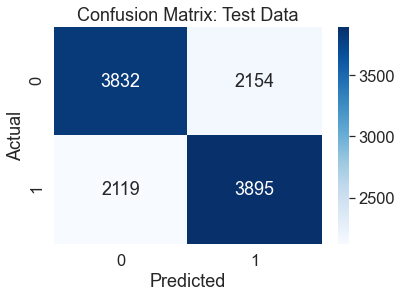

Confusion matrix test
[[3832 2154]
 [2119 3895]]
Classification report test
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      5986
           1       0.64      0.65      0.65      6014

    accuracy                           0.64     12000
   macro avg       0.64      0.64      0.64     12000
weighted avg       0.64      0.64      0.64     12000



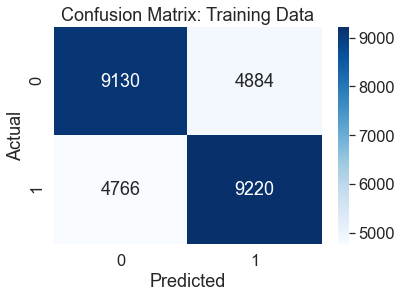

In [45]:
y_pred = logreg.predict(X_test)
y_train_pred = logreg.predict(X_train)

scores("log_reg_opt")

# KNN

Confusion matrix train
[[9130 4884]
 [4766 9220]]
Classification report train
              precision    recall  f1-score   support

           0       0.66      0.65      0.65     14014
           1       0.65      0.66      0.66     13986

    accuracy                           0.66     28000
   macro avg       0.66      0.66      0.66     28000
weighted avg       0.66      0.66      0.66     28000



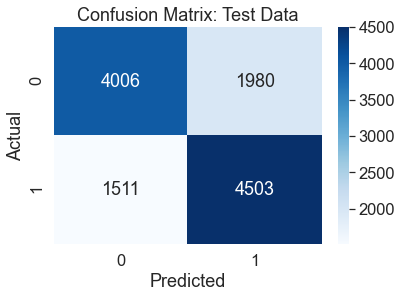

Confusion matrix test
[[4006 1980]
 [1511 4503]]
Classification report test
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      5986
           1       0.69      0.75      0.72      6014

    accuracy                           0.71     12000
   macro avg       0.71      0.71      0.71     12000
weighted avg       0.71      0.71      0.71     12000



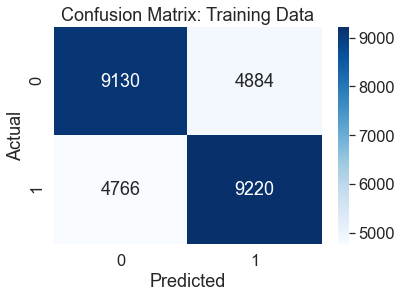

In [46]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, np.ravel(y_train))

y_pred = knn.predict(X_test)
y_test_pred = knn.predict(X_train)

scores("KNN_raw")

## Optimization

In [47]:
# Hyperparameter grid
hyperparameters = {'n_neighbors': np.arange(1, 21, 1),
               'metric': ["euclidean", "manhattan", "minkowski"],
               'weights': ['uniform', 'distance']
               }

# Estimator for use in random search
estimator = KNeighborsClassifier()

# Create the random search model
KNN = RandomizedSearchCV(estimator, hyperparameters,
                         n_jobs=-1,
                         scoring='recall',
                         cv=5,
                         n_iter=25,
                         verbose=1)

# Fit
KNN.fit(X_train, y_train)

print(KNN.best_params_)
print(round(KNN.best_score_,2))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  2.4min finished


{'weights': 'distance', 'n_neighbors': 19, 'metric': 'manhattan'}
0.92


Note: Best params on 07.October were: {'weights': 'distance', 'n_neighbors': 6, 'metric': 'euclidean'}

In [48]:
optimization_plots(KNN)

None


mean_test_score,mean_fit_time,mean_score_time,param_weights,param_n_neighbors,param_metric
0.923209,0.413007,16.9777,distance,19,manhattan


None


Confusion matrix train
[[9130 4884]
 [4766 9220]]
Classification report train
              precision    recall  f1-score   support

           0       0.66      0.65      0.65     14014
           1       0.65      0.66      0.66     13986

    accuracy                           0.66     28000
   macro avg       0.66      0.66      0.66     28000
weighted avg       0.66      0.66      0.66     28000



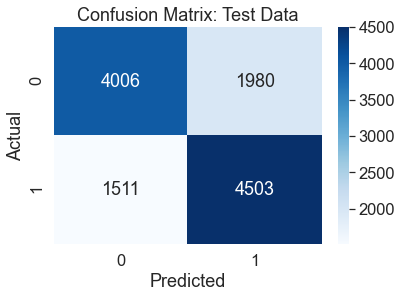

Confusion matrix test
[[4006 1980]
 [1511 4503]]
Classification report test
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      5986
           1       0.69      0.75      0.72      6014

    accuracy                           0.71     12000
   macro avg       0.71      0.71      0.71     12000
weighted avg       0.71      0.71      0.71     12000



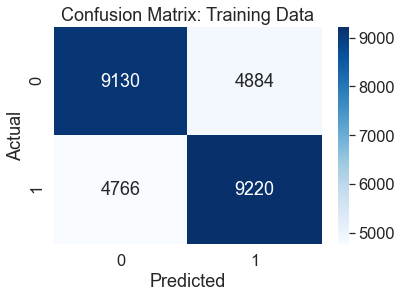

In [49]:
scores("KNN_opt")

# Naive Baise GaussianNB

Confusion matrix train
[[9130 4884]
 [4766 9220]]
Classification report train
              precision    recall  f1-score   support

           0       0.66      0.65      0.65     14014
           1       0.65      0.66      0.66     13986

    accuracy                           0.66     28000
   macro avg       0.66      0.66      0.66     28000
weighted avg       0.66      0.66      0.66     28000



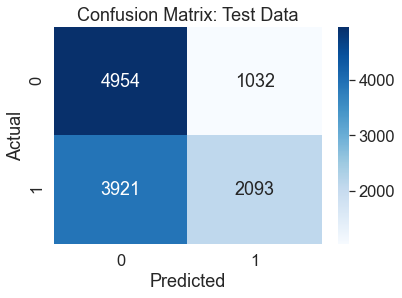

Confusion matrix test
[[4954 1032]
 [3921 2093]]
Classification report test
              precision    recall  f1-score   support

           0       0.56      0.83      0.67      5986
           1       0.67      0.35      0.46      6014

    accuracy                           0.59     12000
   macro avg       0.61      0.59      0.56     12000
weighted avg       0.61      0.59      0.56     12000



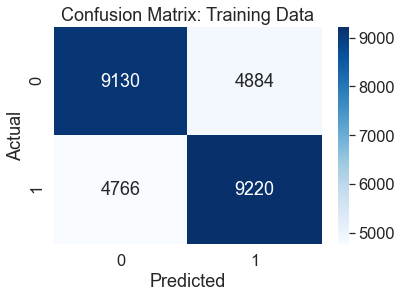

In [50]:
from sklearn.naive_bayes import GaussianNB

gauss = GaussianNB()
gauss.fit(X_train, y_train)
y_pred = gauss.predict(X_test)
y_test_pred = gauss.predict(X_train)

scores("gaussian_raw")

## Optimization

In [51]:
# Param grid
hyperparameters = {
    'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}

# Estimator for use in random search
estimator = GaussianNB()

# Create the random search model
gauss = RandomizedSearchCV(estimator, hyperparameters,
                         n_jobs=-1,
                         scoring='recall',
                         cv=5,
                         n_iter=30,
                         verbose=1)

# Fit
gauss.fit(X_train, y_train)

print(gauss.best_params_)
print(round(gauss.best_score_, 2))

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'var_smoothing': 0.001}
0.49


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.9s finished


Note: Best params on 07.October were: {'var_smoothing': 1e-15}

In [52]:
optimization_plots(gauss)

None


mean_test_score,mean_fit_time,mean_score_time,param_var_smoothing
0.488345,0.1403,0.0312636,0.001


None


Confusion matrix train
[[9130 4884]
 [4766 9220]]
Classification report train
              precision    recall  f1-score   support

           0       0.66      0.65      0.65     14014
           1       0.65      0.66      0.66     13986

    accuracy                           0.66     28000
   macro avg       0.66      0.66      0.66     28000
weighted avg       0.66      0.66      0.66     28000



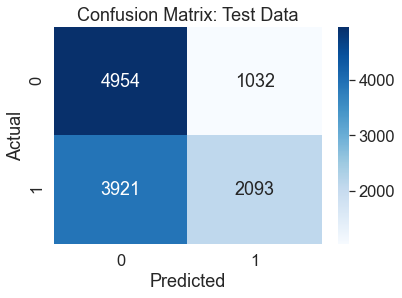

Confusion matrix test
[[4954 1032]
 [3921 2093]]
Classification report test
              precision    recall  f1-score   support

           0       0.56      0.83      0.67      5986
           1       0.67      0.35      0.46      6014

    accuracy                           0.59     12000
   macro avg       0.61      0.59      0.56     12000
weighted avg       0.61      0.59      0.56     12000



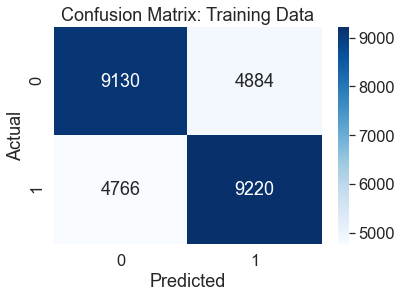

In [53]:
scores("gaussian_opt")